# KNN Classisfication & Heart Disease

## Introduction

**Heart diseases**, which are often caused by the narrowing of blood vessels, are the most common cause of death globally (CDC 2022). In this analysis, we will determine: **Can we predict a heart disease diagnosis based on age, serum cholesterol, resting blood pressure, maximum heart rate, and exercised-induced ST Depression, using KNN Classification?**.

The *Heart Disease* dataset (1988) contains patients' health information, such as the patient's age and cholesterol, including the mentioned predictors in the question. This includes the patients' heart disease diagnoses. The diagnosis is categorical, including 0 (indicating absence of heart disease) and 1 (indicating presence of heart disease). Here, the diagnosis for heart disease indicates >50% narrowing in any major blood vessel. The data is provided from four different locations, which must be combined before it is analyzed.

***
## Preliminary Exploratory Data Analysis

In [24]:
# Install these libraries before continuing
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Reading and Wrangling

In [25]:
# Reading data from web (stored in github repo)
cleveland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.cleveland.csv"
hungarian_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.hungarian.csv"
switzerland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.switzerland.csv"
beach_url <-  "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.va.csv"

names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thanl", "num")

cleveland <- read_csv(cleveland_url, col_names = names)
hungarian <- read_csv(hungarian_url, col_names = names)
switzerland <- read_csv(switzerland_url, col_names = names)
beach <- read_csv(beach_url, col_names = names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thanl
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thanl
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thanl
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to r

In [26]:
# Changing all columns to doubles to be able to combine the 4 dataframes

cleveland <- mutate_all(cleveland, as.double)
hungarian <- mutate_all(hungarian, as.double)
switzerland <- mutate_all(switzerland, as.double)
beach <- mutate_all(beach, as.double)

heart_data_combined <- bind_rows(cleveland, hungarian, switzerland, beach)
heart_data_combined

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = .Primitive("as.double")(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,2
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,0
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


While some of the data uses a scale from 0 to 4 to rank the severity of the heart disease diagnosis, values 1 to 4 all indicate the presence of heart disease. So, this scale can be converted to a 0 to 1 scale.

In [27]:
heart_data <- heart_data_combined |>
                mutate(num = ifelse(num %in% 1:4, 1, num)) |> # Correcting scaling of heart disease data (num)
                filter(chol != 0) |> # There is one incorrect point where chol = 0
                mutate(num = as_factor(num))

In [28]:
# Remove observations with NA values for predictor variables (age, chol, trestbps, thalach, oldpeak) only
heart_data <- heart_data |>
                filter(!is.na(age), !is.na(chol), !is.na(trestbps), !is.na(thalach), !is.na(oldpeak)) 

heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
54,0,4,127,333,1,1,154,0,0,NA,NA,NA,1
55,1,4,122,223,1,1,100,0,0,NA,NA,6,1
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


In [29]:
# Split data into training (80%) and testing (20%) data
set.seed(1234)
heart_split <- initial_split(heart_data, prop = 0.80, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
54,0,4,127,333,1,1,154,0,0,NA,NA,NA,1
55,1,4,122,223,1,1,100,0,0,NA,NA,6,1
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
53,1,4,140,203,1,2,155,1,3.1,3,0,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
61,1,4,190,287,1,2,150,1,2,3,NA,NA,1
57,1,4,122,264,0,2,100,0,0,NA,NA,NA,1
62,1,4,160,254,1,1,108,1,3,2,NA,NA,1


### Summarizing

**Mean**

In [30]:
heart_predictors <- heart_train |>
                    select(age, chol, trestbps, thalach, oldpeak)
        
heart_means <- map_df(heart_predictors, mean)
heart_means

age,chol,trestbps,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52.68901,248.1173,132.5028,141.8212,0.8962756


**Ranges**

In [31]:
# Minimum
heart_min <- heart_predictors |>
                    map_df(min)
heart_min

age,chol,trestbps,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,85,92,69,0


In [32]:
# Maximum

heart_max <- heart_predictors |>
                    map_df(max)
heart_max

age,chol,trestbps,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,603,200,202,6.2


**Count of each class**

In [33]:
heart_obs <- heart_train |>
                group_by(num) |>
                summarize(num_count = n())

heart_obs

num,num_count
<fct>,<int>
0,283
1,254


### Visualizing the Data

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


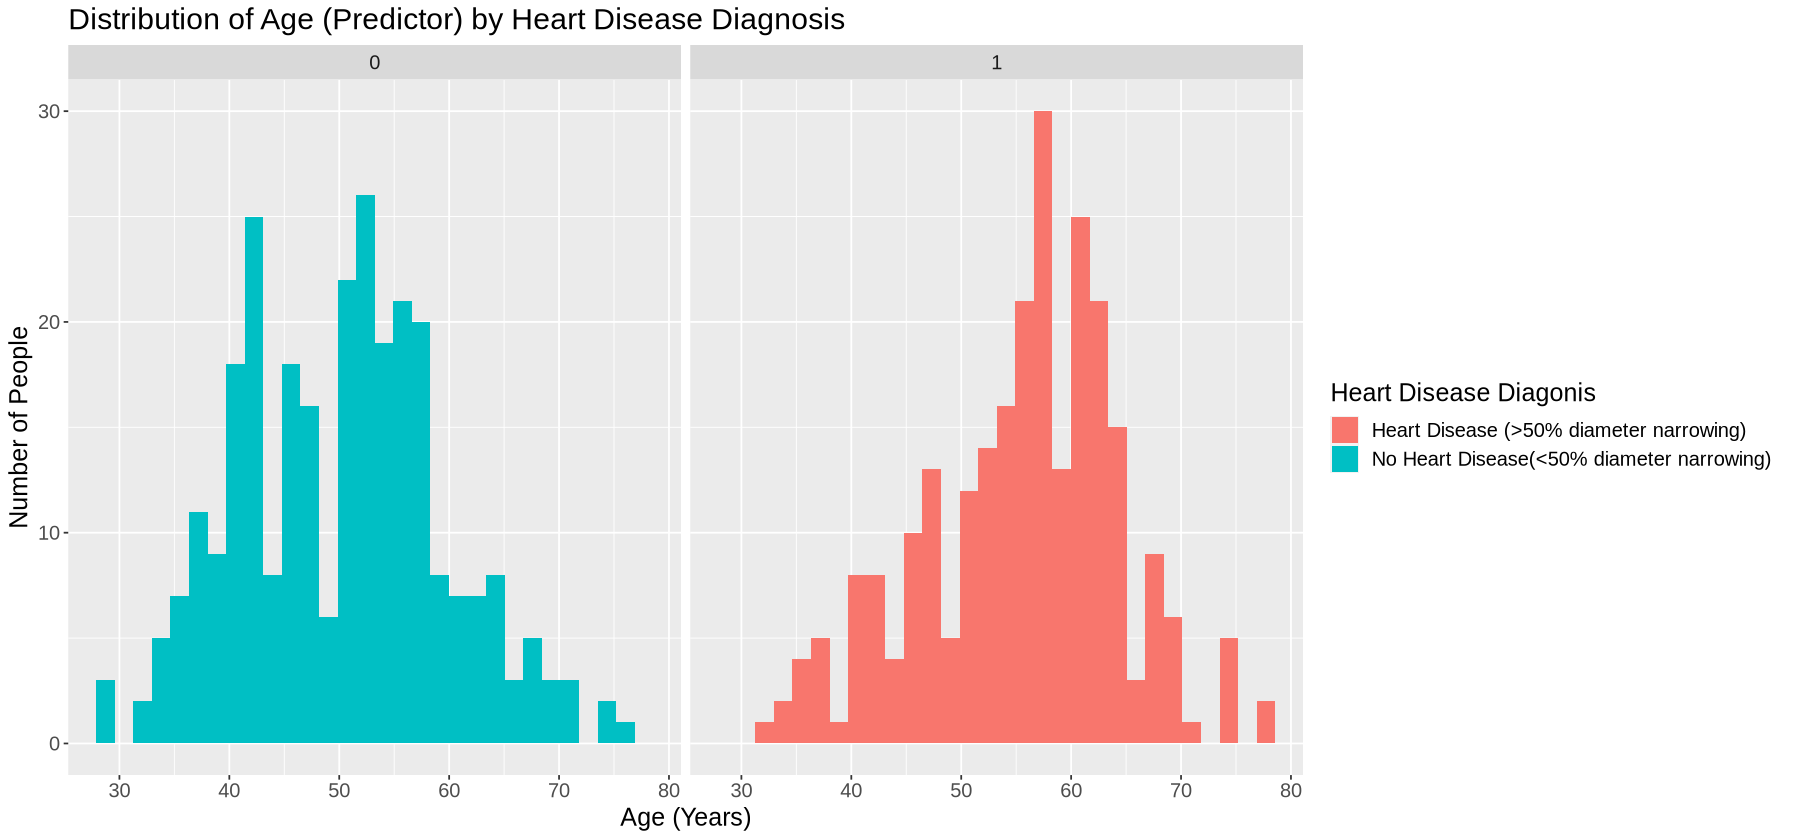

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


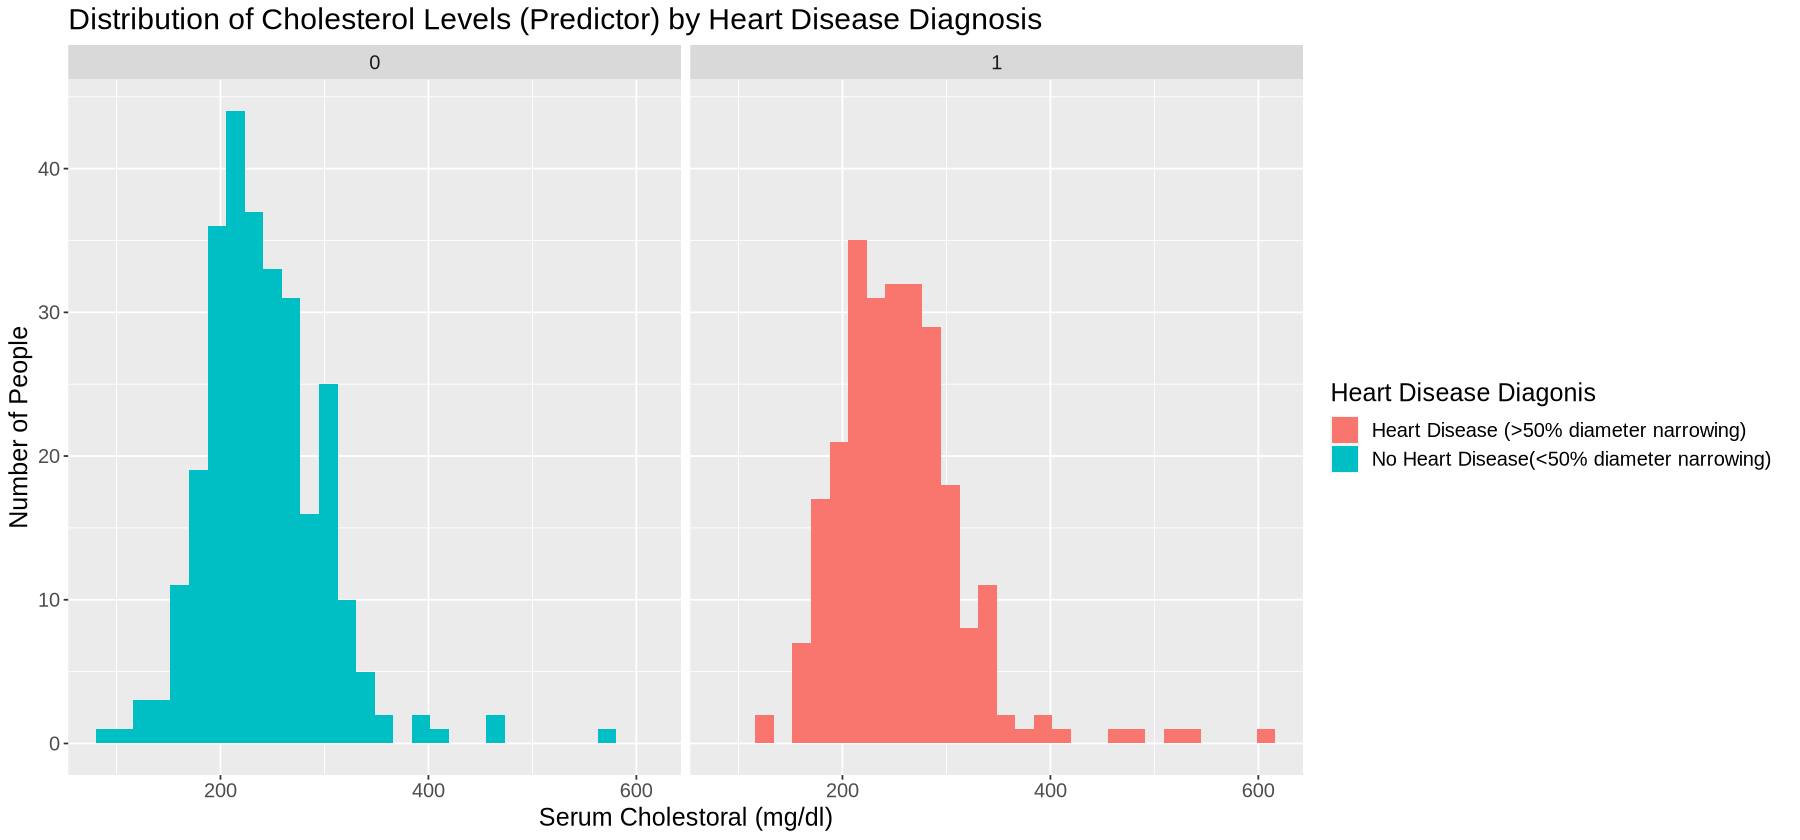

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


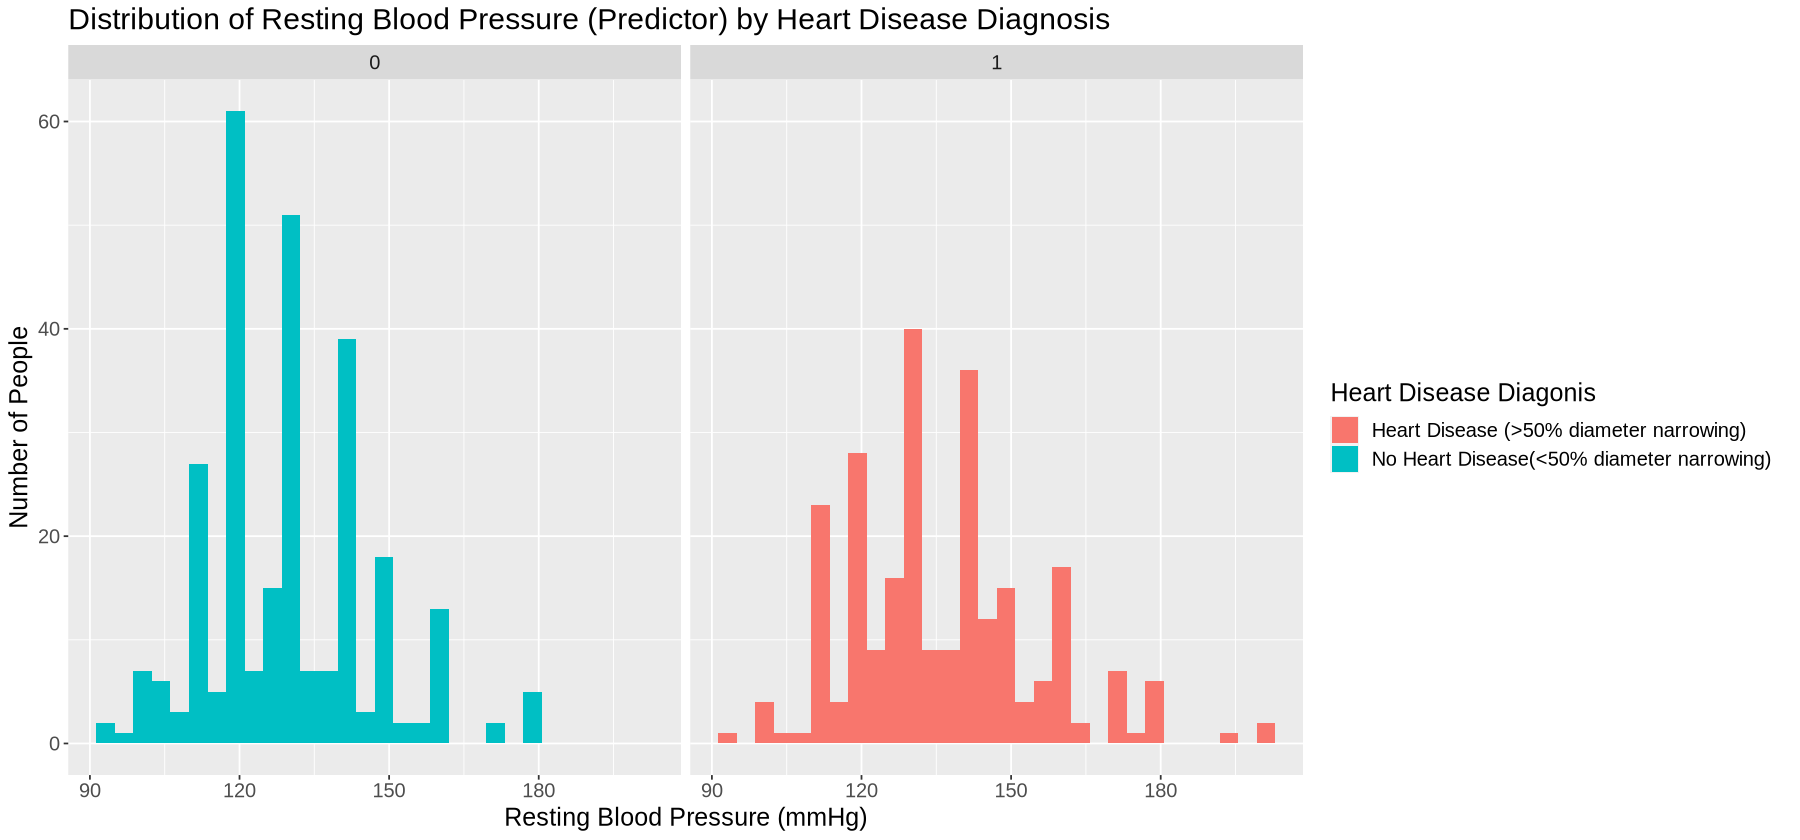

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


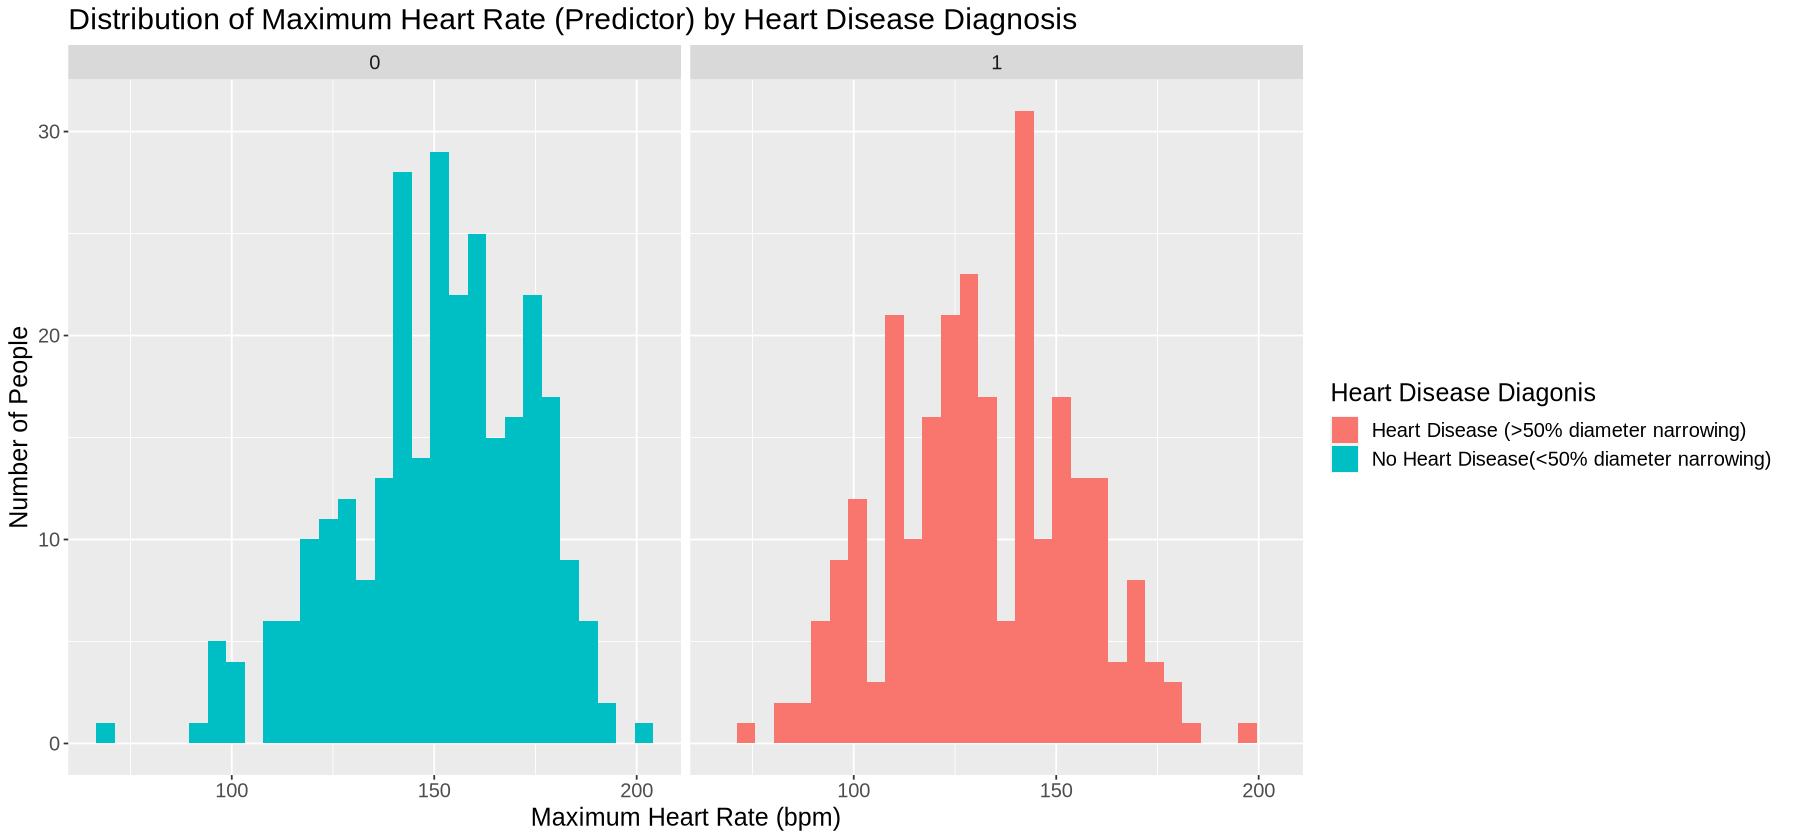

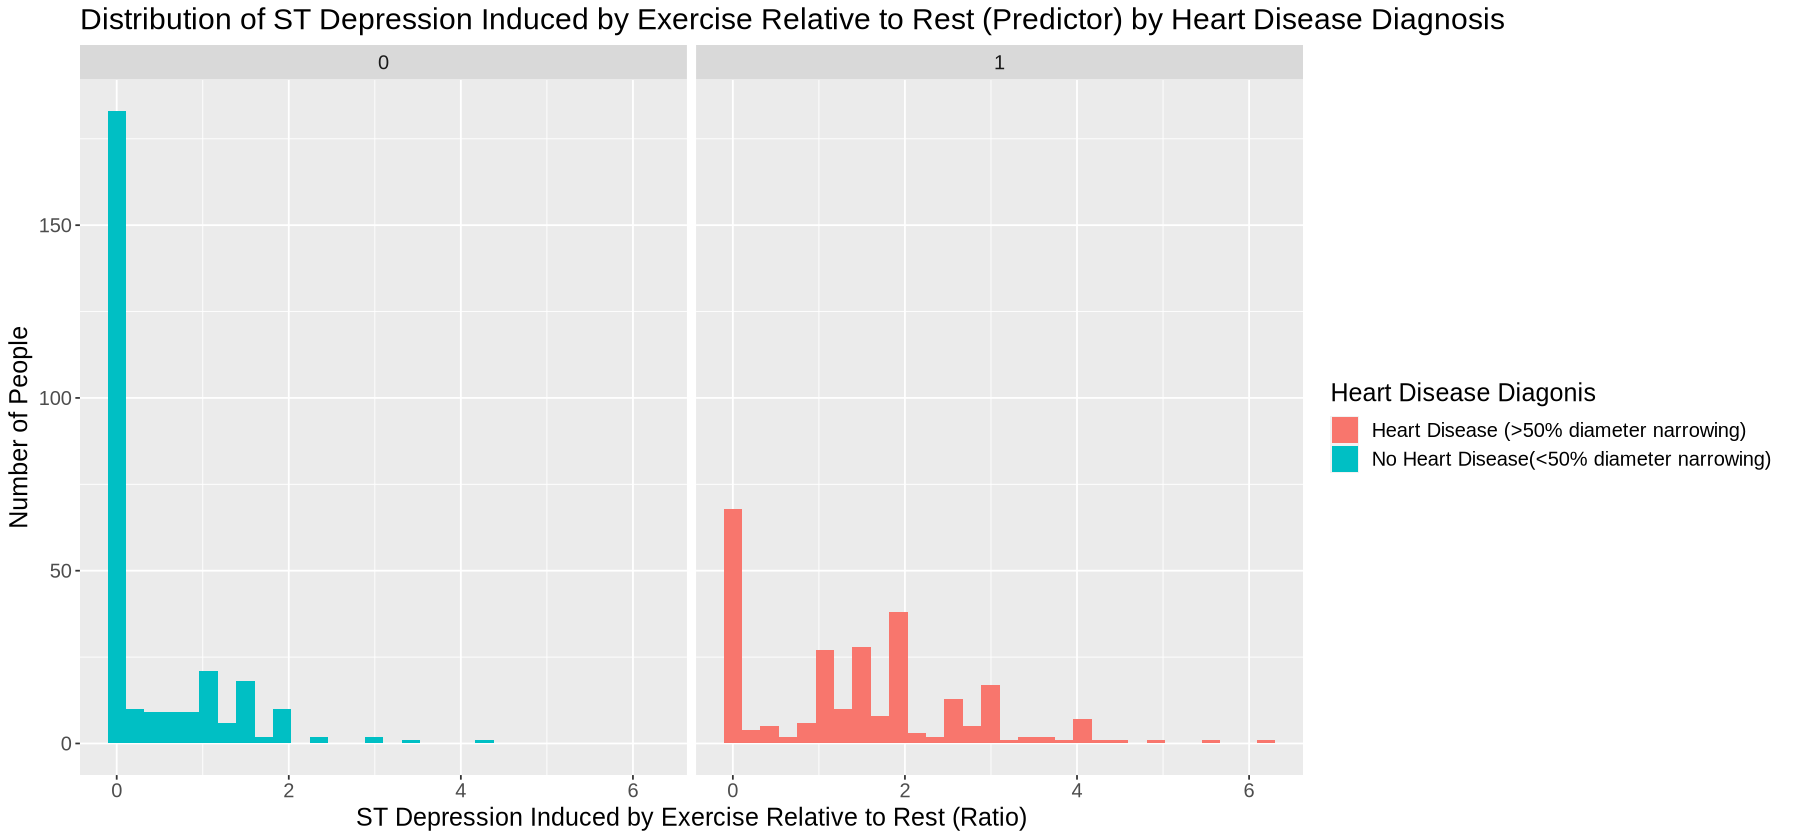

In [34]:
# Plots visualizing distribution of each variable, separated by diagnosis of heart disease

options(repr.plot.width = 15) # Alter to fit screen

# Renaming num (plots only to make the legend clearer
heart_train_renamed_num <- heart_train |>
                            mutate(diagnosis = case_when(
                                num == 0 ~ "No Heart Disease(<50% diameter narrowing)",
                                num == 1 ~ "Heart Disease (>50% diameter narrowing)"
                            ))

y_lab = "Number of People"
leg_lab = "Heart Disease Diagonis"
text_size = 15

plot_age <- ggplot(heart_train_renamed_num, aes(x = age)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Age (Years)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Age (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_chol <- ggplot(heart_train_renamed_num, aes(x = chol)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Serum Cholestoral (mg/dl)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Cholesterol Levels (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_trestbps <- ggplot(heart_train_renamed_num, aes(x = trestbps)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Resting Blood Pressure (mmHg)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Resting Blood Pressure (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_thalach <- ggplot(heart_train_renamed_num, aes(x = thalach)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Maximum Heart Rate (bpm)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Maximum Heart Rate (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_oldpeak <- ggplot(heart_train_renamed_num, aes(x = oldpeak)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "ST Depression Induced by Exercise Relative to Rest (Ratio)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    theme(text = element_text(size = text_size)) +
    ggtitle("Distribution of ST Depression Induced by Exercise Relative to Rest (Predictor) by Heart Disease Diagnosis") 

plot_age
plot_chol
plot_trestbps
plot_thalach
plot_oldpeak

***
## Methods

### Choosing Predictors

* Age, cholesterol, and blood pressure are key risk factors for heart disease (Jousilahti et al., 1999). Exercised-induced ST depression and maximum heart rate have also been used in the prediction of heart disease (Bobbio et al., 1992). These relationships are reflected in the above histograms, because the distribution for each variable changes when considering heart disease.
* They are quantitative variables which means they will be better for scaling and centering. Categorical variables like sex are hard to be given a specific number to scale.

### KNN Classification
1. We will standardize our data, reducing the bias caused by the size of our data. For example, the range for age is between **28 and 77**, but for chol, the range is between **85 and 603**! If we don't standardize this, chol will have a larger effect on the prediction.


In [23]:
heart_max
heart_min

age,chol,trestbps,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,603,200,202,6.2


age,chol,trestbps,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,85,92,69,0


2. We will use `tune()` to find the best number of neighbors. We will measure prediction accuracy using **5-fold cross-validation**. The best number of neighbors will have the highest prediction accuracy. We must find it to make our prediction more accurate.
3. Then we will use KNN classification with the best number of neighbors to predict the diagnosis for a new observation.


### Visualizing Results

1. We will use a metric table to show the accuracy of prediction about our model.
2. We will also use a confusion matrix to show the actual number of our prediction.
3. We will use a bar graph to represent the confusion matrix

***
## Expected Outcomes and Significance

We expect to produce a model that can predict heart disease based on age, cholesterol, resting blood pressure, maximum heart rate, and exercise-induced ST depression. The impact of this model may include more accurate heart disease screening, reducing the burden on the healthcare system. This could also lead to discovering variables that have the greatest impact on heart disease, which can provide dietary and lifestyle suggestions for people with higher risks of heart disease.

***
### Citations

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. *Heart Disease* UCI Machine Learning Repository [Data set]. https://doi.org/10.24432/C52P4X

Jousilahti, P., Vartiainen, E., Tuomilehto, J., Puska, P. Sex, Age, Cardiovascular Risk Factors, and Coronary Heart Disease. (1999). *Circulation, 99*, 1165-1172.  https://doi.org/10.1161/01.CIR.99.9.1165

Bobbio, M., Detrano, R., Schmid, J., Janosi, A., Righetti, A., Steinbrunn, W., Guppy, K., Abi-Mansour, P., Deckers, J., Colombo, A., Lehmann, K., Olson, H. (1992). Exercise-induced ST depression and ST/heart rate index to predict triple-vessel or left main coronary disease: A multicenter analysis. *Journal of American College of Cardiology, 19(1)*, 11-18. https://doi.org/10.1016/0735-1097(92)90044-N

*Heart Disease and Stroke.* (2022 8 September). CDC. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=The%20Nation's%20Risk%20Factors%20and,unhealthy%20diet%2C%20and%20physical%20inactivity.


Citations and in-text citations excluded from word count.